# Introduction

This tutorial demonstrates how to run Subtype and Stage Inference (SuStaIn) using simulated data. SuStaIn is an unsupervised learning algorithm that identifies subgroups of individuals with distinct biomarker progression patterns. See [Young et al. Nature Communications 2018](https://doi.org/10.1038/s41467-018-05892-0) for more details.

SuStaIn is a generalisable algorithm in which you can choose how to model the progression of biomarkers within a subtype. Here we demonstrate this using the z-score model used in [Young et al. Nature Communications 2018](https://doi.org/10.1038/s41467-018-05892-0). Other notebooks on the [repo](https://github.com/ucl-pond/pySuStaIn/tree/master/notebooks) can be found for the mixture and ordinal models of SuStaIn.

For any questions on SuStaIn, please email alexandra.young@kcl.ac.uk. For questions on the code, please email leon.aksman@ucl.ac.uk or raise an issue on the [main GitHub repo](https://github.com/ucl-pond/pySuStaIn).

# Z-Score SuStaIn

The linear z-score model describes a subtype progression pattern as the linear evolution of biomarkers between different z-scores. Figure 1 below shows an example of what this model looks like for a single subtype. The model is indexed by a set of discrete stages. Each stage corresponds to a biomarker reaching a new z-score from the set of z-scores for each biomarker, `Z_vals`. Each biomarker starts with a minimum value of 0 at stage 0 and reaches a maximum of `Z_max` at the final stage of the progression. The number of stages is determined by the number of biomarkers and z-scores in `Z_vals`. The SuStaIn algorithm identifies subgroups of individuals and their progression patterns - for the linear z-score model the progression pattern would be the ordering of the different biomarker z-scores in `Z_vals` (`ground_truth_sequence` below).

## Preparation

In [1]:
# Initial imports
import shutil
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pySuStaIn
# Set number of biomarkers, samples, and subtypes
n_biomarkers = 5
n_samples = 500
n_subtypes = 2
# Set the random number seed
seed = 42
# The fraction of people/samples in each subtype
subtype_fractions = np.array([0.6, 0.4])
# Sample the actual subtype each sample will belong to
ground_truth_subtypes = np.random.RandomState(seed).choice(
    range(n_subtypes), n_samples, replace=True, p=subtype_fractions
).astype(int)

Let's create some z-scores for our data.

In [2]:
# Set the seed for this run
np.random.seed(seed)
# Z-scores for each biomarker
Z_vals = np.tile([1,2,3], (n_biomarkers, 1))
# Maximum z-score
Z_max = np.full(n_biomarkers, 5)

Now we can set different biomarkers to have different z-scores. Below, we'll set biomarker 0 to have z-scores of 1 and 2 only, with a maximum of 3.

In [3]:
Z_vals[0,2] = 0
Z_max[0] = 3

In [4]:
# Generate a random sequence for the linear z-score model
ground_truth_sequence = pySuStaIn.ZscoreSustain.generate_random_model(
    Z_vals, n_subtypes
)

In [5]:
n_stages = ground_truth_sequence.shape[1]
ground_truth_stages_control = np.zeros((int(np.round(n_samples * 0.25)), 1))
ground_truth_stages_other = np.random.randint(1, n_stages+1, (int(np.round(n_samples * 0.75)), 1))
ground_truth_stages = np.vstack((ground_truth_stages_control, ground_truth_stages_other)).astype(int)

data, data_denoised, stage_value = pySuStaIn.ZscoreSustain.generate_data(
    ground_truth_subtypes,
    ground_truth_stages,
    ground_truth_sequence,
    Z_vals,
    Z_max
)

Using the ground truth, we can plot the progression of the z-scores for each biomarker for each of the subtypes. You can play around generating different sequences and altering the settings of the linear z-score model with the parameters above.

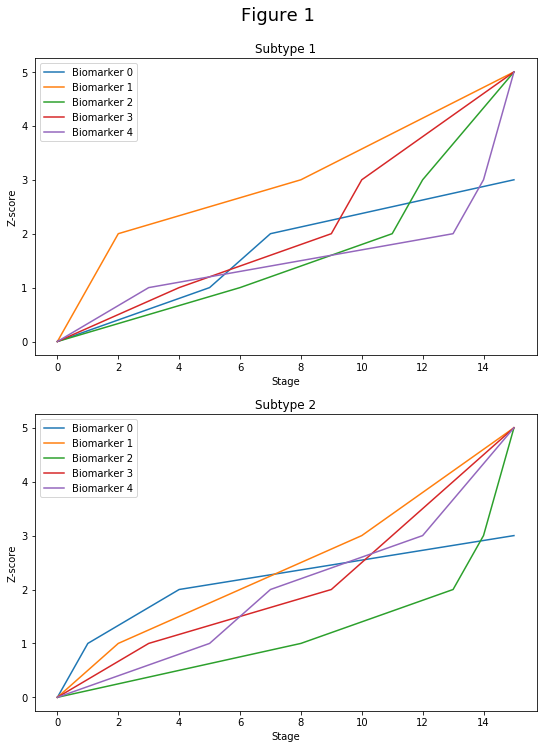

In [6]:
fig, axes = plt.subplots(n_subtypes, 1, figsize=(9, 6*n_subtypes))
fig.suptitle("Figure 1", fontsize=18, x=0.5, y=0.94)
for ax, subtype in zip(axes, range(n_subtypes)):
    for biomarker in range(n_biomarkers):
        ax.plot(
            range(len(Z_vals.flatten())+1),
            stage_value[biomarker, :, subtype],
            label=f"Biomarker {biomarker}"
        )
    ax.set_title(f"Subtype {subtype+1}")
    ax.set_xlabel("Stage")
    ax.set_ylabel("Z-score")
    ax.legend(loc="upper left")

The z-score model assumes individuals belong to some unknown stage of this progression, with Gaussian noise (standard deviation of 1) for each biomarker.

### Important note on linear z-score model
It's natural to think of the progression pattern in Figure 1 as linear in time but this isn't necessarily the case. For example, the time between stages 2 and 3 may be much longer than between stages 8 and 9. This means that the shape of the trajectories may look quite different if indexed by time (although the general order in which the biomarkers progress to different z-scores would remain the same). The linear z-score model simply describes the patient snapshots you would expect to see in a cross-sectional dataset for any particular subtype at a particular stage. The subtypes and stages are considered as hidden variables, which the SuStaIn algorithm identifies directly from the data.

## Preparing the Data (z-scores)
The data needs to be z-scored relative to a control population such that the mean of the control population is 0. 

## Running SuStaIn

### `ZscoreSustain` Parameters
`data`: The data you want to run SuStaIn on. z-scored in the way described above. Typically, a `numpy` array of shape `n_subjects` by `n_biomarkers`.

`Z_vals`: This is the set of z-scores you want to include for each biomarker. The more z-scores you use the longer the SuStaIn algorithm will take to run. Z_vals has size `n_biomarkers` by Z z-scores. If you have more z-scores for some biomarkers than others you can simply leave zeros at the end of biomarker rows with fewer z-scores.

`Z_max`: The maximum z-score reached at the end of the progression, with size N biomarkers by 1. We'd suggest choosing a value around the 95th percentile of your data but you can experiment with different values. We typically choose an integer for interpretability, but you don't have to.

`biomarker_labels`: The names of the biomarkers you are using (for plotting purposes).

`N_startpoints`: The number of startpoints to use when fitting the subtypes hierarchichally. Generally we suggest using 25.

`N_S_max`: The maximum number of subtypes to fit. Generally we recommend starting with a lower number - maybe three - and then increasing that if you're getting a significantly better fit with the maximum number of subtypes. You can judge this roughly from the MCMC plot. To properly evaluate the optimal number of subtypes you need to run cross-validation (which we discuss later).

`N_iterations_MCMC`: The number of iterations for the MCMC sampling of the uncertainty in the progression pattern. We'd recommend using $1 \times 10^5$ or $1 \times 10^6$.

`output_folder`: A path or name for an output folder to save the results.

`dataset_name`: The name used in the results files outputted by SuStaIn.

`use_parellel_startpoints`: Boolean for whether or not to parallelize the startpoints.

`seed`: The seed number to use (for reproducibility).

### Exact computation
There are approximate and exact versions of the computation of the data likelihood for the linear z-score model. Currently the python version only supports the approximate version. If you want to use the exact version please see the Matlab version at https://github.com/ucl-pond/SuStaInMatlab.

Below we will set these parameters and create the model. Note that we are using lower values here (especially the number of MCMC iterations) for faster computation.

In [7]:
# Delete the comments below after finishing the table above

# Set the params for SuStaIn
sustain_kwargs = {
    "N_startpoints": 10,
    "N_S_max": n_subtypes+1,
    "N_iterations_MCMC": int(1e4),
    "dataset_name": "sim",
    "biomarker_labels": [f"Biomarker {i}" for i in range(n_biomarkers)],
    "use_parallel_startpoints": True,
    "seed": seed
}
# Set the output folder
sustain_kwargs["output_folder"] = "zscore_sustain"
# For a clean run, remove previous results if present
if (Path.cwd() / sustain_kwargs["output_folder"]).is_dir():
    shutil.rmtree(sustain_kwargs["output_folder"])
# Create clean folder
(Path.cwd() / "zscore_sustain").mkdir(parents=True, exist_ok=True)
# Create the model object
sustain_zscore_model = pySuStaIn.ZscoreSustain(
    data, Z_vals, Z_max, **sustain_kwargs
)

Now everything is set up, we can run SuStaIn.

Failed to find pickle file: zscore_sustain/pickle_files/sim_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem


MCMC Iteration:   1%|          | 65/10000 [00:00<00:15, 649.43it/s]

Overall ML likelihood is -4311.96218194868


MCMC Iteration: 100%|██████████| 10000/10000 [00:14<00:00, 678.85it/s]
/home/cshand/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Failed to find pickle file: zscore_sustain/pickle_files/sim_subtype1.pickle. Running SuStaIn model for 1 subtype.
Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


MCMC Iteration:   0%|          | 34/10000 [00:00<00:30, 331.13it/s]

- ML likelihood is [-4279.48390023]
Overall ML likelihood is [-4279.48390023]


MCMC Iteration: 100%|██████████| 10000/10000 [00:29<00:00, 333.78it/s]


Failed to find pickle file: zscore_sustain/pickle_files/sim_subtype2.pickle. Running SuStaIn model for 2 subtype.
Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-4273.21133478]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


MCMC Iteration:   0%|          | 19/10000 [00:00<00:54, 181.94it/s]

- ML likelihood is [-4271.83534019]
Overall ML likelihood is [-4271.83534019]


MCMC Iteration: 100%|██████████| 10000/10000 [00:43<00:00, 228.04it/s]


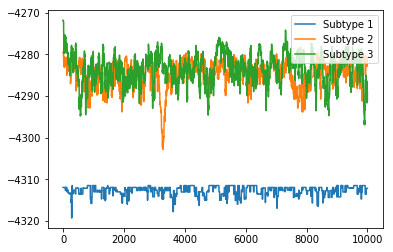

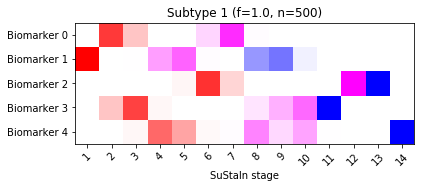

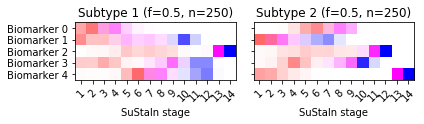

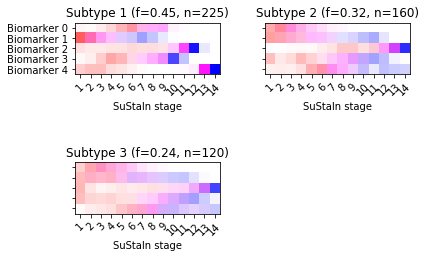

In [8]:
_ = sustain_zscore_model.run_sustain_algorithm(plot=True)

Just to illustrate, if we run it again we load the pickled files, enabling quicker visualisation

Found pickle file: zscore_sustain/pickle_files/sim_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: zscore_sustain/pickle_files/sim_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: zscore_sustain/pickle_files/sim_subtype2.pickle. Using pickled variables for 2 subtype.


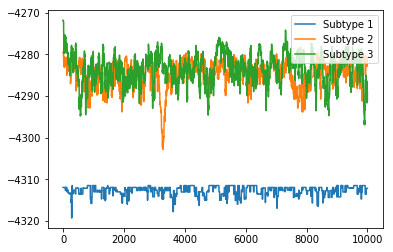

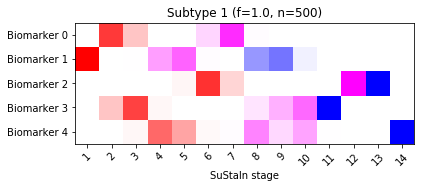

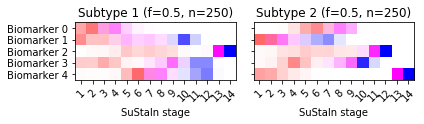

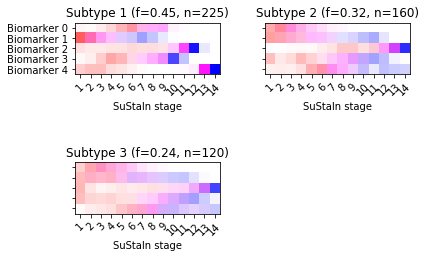

In [9]:
_ = sustain_zscore_model.run_sustain_algorithm(plot=True)

### Comparison with ground truth

Figure 2 shows the expected progression patterns for the simulated data in the form of positional variance diagrams so it's easier to compare the output of SuStaIn with the ground truth from the simulated data. In a positional variance diagram each entry tells you the probability each biomarker has reached each z-score at each SuStaIn stage. Here, z-scores of 1 are shown in red, 2 in magenta and 3 in blue. I've plotted the positional variance diagrams in Figure 3 without any uncertainty. You'd expect the results from the simulated dataset to have a similar progression pattern on average to those in Figure 3, but with uncertainty due to the simulated noise. Figure 4 shows the output of SuStaIn for the ground truth number of subtypes.

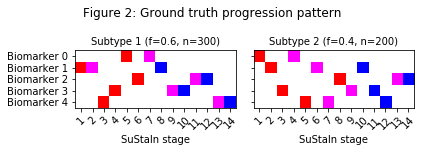

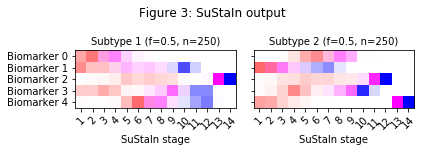

In [10]:
# Plot ground truth
sustain_zscore_model._plot_sustain_model(
    ground_truth_sequence[:, :, None], subtype_fractions[:, None], n_samples
)
_ = plt.suptitle('Figure 2: Ground truth progression pattern', y=0.75)

# Plot SuStaIn output
s = n_subtypes - 1
pickle_filepath = Path(
    sustain_zscore_model.output_folder
) / "pickle_files" / f"{sustain_zscore_model.dataset_name}_subtype{s}.pickle"

with open(pickle_filepath, "rb") as pickle_file:
    loaded_variables = pickle.load(pickle_file)
    samples_sequence = loaded_variables["samples_sequence"]
    samples_f = loaded_variables["samples_f"]

sustain_zscore_model._plot_sustain_model(
    samples_sequence, samples_f, n_samples
)
_ = plt.suptitle('Figure 3: SuStaIn output', y=0.75)

## Assessing the output

Now we've run the SuStaIn algorithm, we need to assess the output and decide whether to change any of the settings. 

### MCMC trace

The first thing to look at is the MCMC trace (Figure 5 below). It should be periodic, i.e. with a structure that regularly repeats itself, rather than having long flat sections where it gets stuck at a particular likelihood. If this isn't the case SuStaIn is not working well on your data. There's some troubleshooting you can try:
- Check that your data is z-scored correctly
- Check that the choice of z-scores (Z_vals and Z_max) are sensible
- Check that your data looks normally distributed in your control population
-- if not, try an alternative version of SuStaIn that might be more suitable for your data, e.g. SuStaIn using a KDE event-based model for non normally distributed data 
- Increase the number of startpoints (N_startpoints)
- Increase the number of MCMC samples (N_iterations_MCMC)

### Histograms of model likelihood
The next thing to look at are histograms of the model likelihood (Figure 6 below). Whilst the number of subtypes should be determined through cross-validation, these histograms can give a reasonable indication of the number of subtypes in your dataset, which will enable you to decide whether to fit more subtypes and what to set as the maximum number of subtypes for the cross-validation. When there's a large overlap between the histograms of the model likelihood as you increase the subtypes it means that the likelihood isn't improving very much when you increase the number of subtypes, which means you've probably gone past the optimal number of subtypes. You want to fit enough subtypes so that at least one model is too complex (has too many subtypes) for your data so that you can be sure you've chosen the optimal number of subtypes. If you're not seeing overlapping histograms you need to increase N_S_max and run SuStaIn again from your previous setting of N_S_max.

### Positional variance diagrams
If the end stages of the positional variance diagrams look very blurry with no clear predominant progression pattern, it usually means that there aren't many individuals that fit well with the end stages of the progression. If this is the case you might want to consider removing some biomarker z-scores and re-running SuStaIn.

Text(0, 0.5, 'Number of samples')

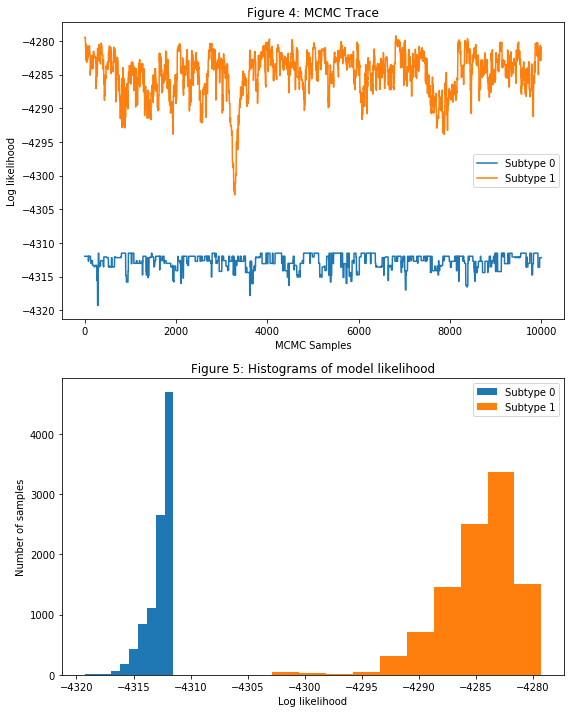

In [11]:
# go through each subtypes model and plot MCMC samples of the likelihood
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))

for s in range(n_subtypes):
    pickle_filepath = Path(
        sustain_zscore_model.output_folder
    ) / "pickle_files" / f"{sustain_zscore_model.dataset_name}_subtype{s}.pickle"

    with open(pickle_filepath, "rb") as pickle_file:
        loaded_variables = pickle.load(pickle_file)
        samples_likelihood = loaded_variables["samples_likelihood"]
    
    ax1.plot(
        range(sustain_zscore_model.N_iterations_MCMC),
        samples_likelihood,
        label=f"Subtype {s}"
    )
    ax2.hist(
        samples_likelihood,
        label=f"Subtype {s}"
    )

ax1.set_title("Figure 4: MCMC Trace")
ax1.legend(loc="right")
ax1.set_xlabel("MCMC Samples")
ax1.set_ylabel("Log likelihood")

ax2.set_title("Figure 5: Histograms of model likelihood")
ax2.legend(loc="upper right")
ax2.set_xlabel("Log likelihood")
ax2.set_ylabel("Number of samples")

## Cross-Validation

To determine the optimal number of subtypes it's necessary to perform cross-validation and compute the cross-validation information criterion (CVIC). 

### Stratified cross-validation
It's a good idea to use stratified training and test sets so you have similar numbers of cases and controls in each fold, as shown below.

In [12]:
index_control = np.reshape(ground_truth_stages, n_samples)==0
labels = np.ones(data.shape[0], dtype=int)
labels[index_control] = 0

from sklearn.model_selection import StratifiedKFold
n_folds = 3
cv = StratifiedKFold(n_folds, shuffle=True, random_state=seed)
cv_it = cv.split(data, labels)
# Get indices for all test folds
test_idxs = [i[1] for i in cv_it]

### Performing cross-validation
Next we'll run the cross-validation on the training folds and validate on the test folds.

The code below does this sequentially for all folds. It's also possible to specify a specific fold if you wanted to run each fold of the cross-validation separately in parallel (e.g. on the cluster).

Finding ML solution to 1 cluster problem


MCMC Iteration:   1%|          | 56/10000 [00:00<00:17, 559.98it/s]

Overall ML likelihood is -2860.4066074984894


MCMC Iteration: 100%|██████████| 10000/10000 [00:11<00:00, 870.09it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


MCMC Iteration:   0%|          | 33/10000 [00:00<00:31, 320.95it/s]

- ML likelihood is [-2838.35087769]
Overall ML likelihood is [-2838.35087769]


MCMC Iteration: 100%|██████████| 10000/10000 [00:21<00:00, 461.44it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2833.57844466]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


MCMC Iteration:   0%|          | 23/10000 [00:00<00:44, 222.15it/s]

- ML likelihood is [-2833.57957064]
Overall ML likelihood is [-2833.57844466]


MCMC Iteration: 100%|██████████| 10000/10000 [00:29<00:00, 335.86it/s]


Finding ML solution to 1 cluster problem


MCMC Iteration:   1%|          | 78/10000 [00:00<00:12, 771.70it/s]

Overall ML likelihood is -2866.2939712708558


MCMC Iteration: 100%|██████████| 10000/10000 [00:10<00:00, 952.35it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


MCMC Iteration:   0%|          | 33/10000 [00:00<00:30, 327.20it/s]

- ML likelihood is [-2843.17427857]
Overall ML likelihood is [-2843.17427857]


MCMC Iteration: 100%|██████████| 10000/10000 [00:20<00:00, 483.27it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2837.74461356]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


MCMC Iteration:   0%|          | 25/10000 [00:00<00:40, 246.12it/s]

- ML likelihood is [-2838.53131889]
Overall ML likelihood is [-2837.74461356]


MCMC Iteration: 100%|██████████| 10000/10000 [00:29<00:00, 336.15it/s]


Finding ML solution to 1 cluster problem


MCMC Iteration:   1%|          | 71/10000 [00:00<00:14, 707.66it/s]

Overall ML likelihood is -2888.687715558619


MCMC Iteration: 100%|██████████| 10000/10000 [00:10<00:00, 947.30it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


MCMC Iteration:   0%|          | 31/10000 [00:00<00:32, 306.39it/s]

- ML likelihood is [-2867.25504882]
Overall ML likelihood is [-2867.25504882]


MCMC Iteration: 100%|██████████| 10000/10000 [00:20<00:00, 485.42it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2861.79324935]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


MCMC Iteration:   0%|          | 28/10000 [00:00<00:35, 279.46it/s]

- ML likelihood is [-2861.65767671]
Overall ML likelihood is [-2861.65767671]


MCMC Iteration: 100%|██████████| 10000/10000 [00:29<00:00, 338.93it/s]


Average test set log-likelihood for each subtype model: [-1436.37055379 -1428.80675736 -1428.74472009]


/home/cshand/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


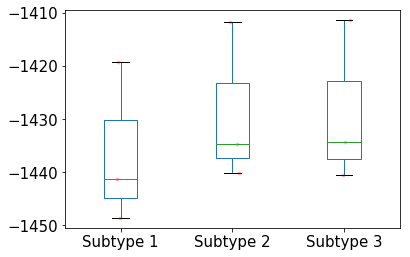

CVIC for each subtype model: [8588.00918341 8531.09833451 8532.29272673]


In [13]:
CVIC, loglike_matrix = sustain_zscore_model.cross_validate_sustain_model(test_idxs)

As before, running this again will load previously saved files:

Loading zscore_sustain/pickle_files/sim_fold0_subtype0.pickle
Loading zscore_sustain/pickle_files/sim_fold0_subtype1.pickle
Loading zscore_sustain/pickle_files/sim_fold0_subtype2.pickle
Loading zscore_sustain/pickle_files/sim_fold1_subtype0.pickle
Loading zscore_sustain/pickle_files/sim_fold1_subtype1.pickle
Loading zscore_sustain/pickle_files/sim_fold1_subtype2.pickle
Loading zscore_sustain/pickle_files/sim_fold2_subtype0.pickle
Loading zscore_sustain/pickle_files/sim_fold2_subtype1.pickle
Loading zscore_sustain/pickle_files/sim_fold2_subtype2.pickle
Average test set log-likelihood for each subtype model: [-1436.37055379 -1428.80675736 -1428.74472009]


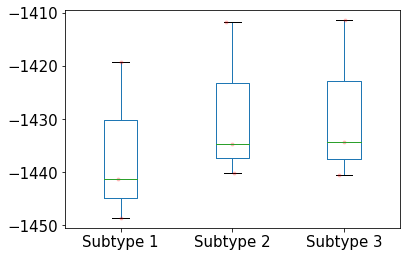

CVIC for each subtype model: [8588.00918341 8531.09833451 8532.29272673]


In [14]:
CVIC, loglike_matrix = sustain_zscore_model.cross_validate_sustain_model(test_idxs)

### Choosing the optimal number of subtypes

The optimal number of subtypes is chosen using the CVIC, shown in Figure 6 below. The CVIC is an information criterion (like the AIC/BIC/WAIC) that balances model complexity with model accuracy, with a lower CVIC indicating a better balance between the two. Generally speaking, the model with the lowest CVIC is the best. However, you do sometimes get a very small improvement (less than ~6) in the CVIC with a more complex model, in which case I would tend to favour the less complex (i.e. fewer subtypes) model.

Another useful metric to look at is the log-likelihood of each subtypes model on the test set, shown in Figure 7. A better model should show a consistent improvement in the test set log-likelihood across folds.

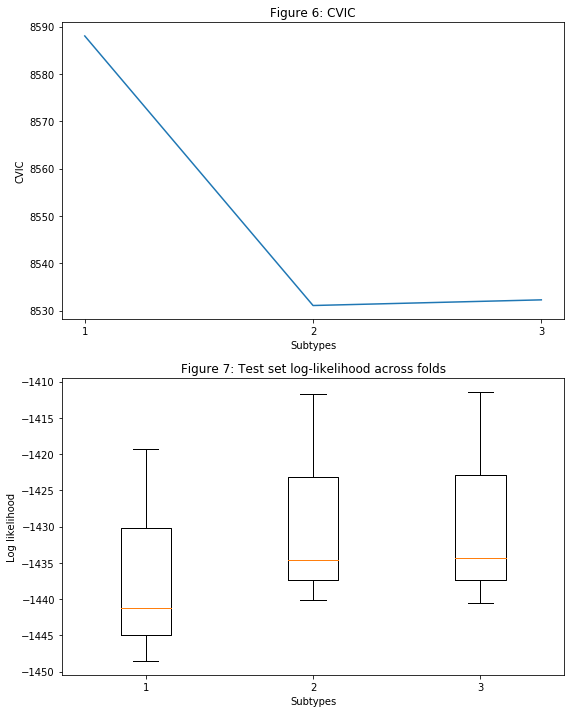

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))

ax1.plot(range(1, n_subtypes+2), CVIC)
ax1.set_xticks(range(1, n_subtypes+2))
ax1.set_xlabel("Subtypes")
ax1.set_ylabel("CVIC")
ax1.set_title("Figure 6: CVIC")

ax2.boxplot(loglike_matrix)
ax2.set_xlabel("Subtypes")
ax2.set_ylabel("Log likelihood")
_ = ax2.set_title("Figure 7: Test set log-likelihood across folds")

### Cross-validated positional variance diagrams
Another useful output of the cross-validation that you can look at are positional variance diagrams averaged across cross-validation folds. These give you an idea of the variability in the progression patterns across different training datasets.

/home/cshand/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


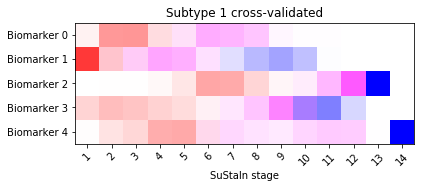

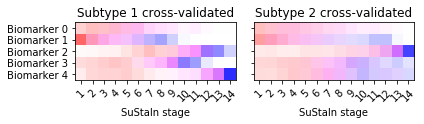

In [16]:
for i in range(n_subtypes):
    sustain_zscore_model.combine_cross_validated_sequences(i+1, n_folds)

Just for visual comparison, let's plot that alongside the ground truth and non-cross-validated output (previously shown in Figures 2 and 3 respectively):

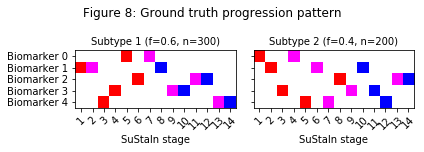

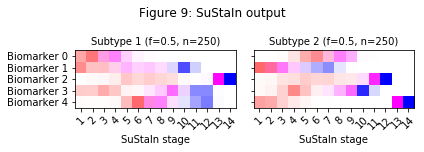

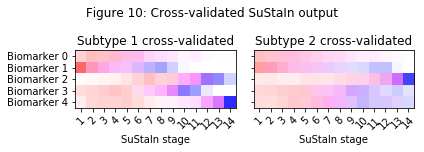

In [17]:
# Plot ground truth
sustain_zscore_model._plot_sustain_model(
    ground_truth_sequence[:, :, None], subtype_fractions[:, None], n_samples
)
_ = plt.suptitle('Figure 8: Ground truth progression pattern', y=0.75)

# Plot SuStaIn output
s = n_subtypes - 1
pickle_filepath = Path(
    sustain_zscore_model.output_folder
) / "pickle_files" / f"{sustain_zscore_model.dataset_name}_subtype{s}.pickle"

with open(pickle_filepath, "rb") as pickle_file:
    loaded_variables = pickle.load(pickle_file)
    samples_sequence = loaded_variables["samples_sequence"]
    samples_f = loaded_variables["samples_f"]

sustain_zscore_model._plot_sustain_model(
    samples_sequence, samples_f, n_samples
)
_ = plt.suptitle('Figure 9: SuStaIn output', y=0.75)

# Plot cross-validated SuStaIn output
sustain_zscore_model.combine_cross_validated_sequences(i+1, n_folds)
_ = plt.suptitle("Figure 10: Cross-validated SuStaIn output", y=0.75)

## Subtyping and staging

Once you've used the CVIC to choose the optimal number of subtypes you can use the SuStaIn output from that subtypes model to subtype and stage individuals in your dataset. This will already have been output by the SuStaIn algorithm, you can extract the outputs using the code below. The outputs are:

* `ml_subtype` and `prob_ml_subtype`: The maximum likelihood subtype and the probability of that subtype for each individual.

* `ml_stage` and `prob_ml_stage`: The maximum likelihood stage and the probability of that stage for each individual.

* `prob_subtype`, `prob_stage`, and `prob_subtype_stage`: The probability each individual belongs to each subtype, to each stage, and to each subtype and stage combination.

In [18]:
s = n_subtypes - 1
pickle_filepath = Path(
    sustain_zscore_model.output_folder
) / "pickle_files" / f"{sustain_zscore_model.dataset_name}_subtype{s}.pickle"

with open(pickle_filepath, 'rb') as pickle_file:
    loaded_variables = pickle.load(pickle_file)
    ml_subtype = loaded_variables["ml_subtype"]
    prob_ml_subtype = loaded_variables["prob_ml_subtype"]
    ml_stage = loaded_variables["ml_stage"]
    prob_ml_stage = loaded_variables["prob_ml_stage"]
    prob_subtype = loaded_variables["prob_subtype"]
    prob_stage = loaded_variables["prob_stage"]
    prob_subtype_stage = loaded_variables["prob_subtype_stage"]           

# You can also subtype and stage new data using
# N_samples                       = 1000
# ml_subtype,                  \
# prob_ml_subtype,             \
# ml_stage,                    \
# prob_ml_stage,               \
# prob_subtype,                \
# prob_stage,                  \
# prob_subtype_stage          = sustain_input.subtype_and_stage_individuals_newData(new_data,N_samples)

# You can also subtype and stage new data using, for example:
# (ml_subtype, prob_ml_subtype, ml_stage,
# prob_ml_stage, prob_subtype, prob_stage,
# prob_subtype_stage) = sustain_zscore_model.subtype_and_stage_individuals_newData(
#   new_data, new_n_samples
# )

## Subtyping and staging using cross-validated models

The code below subtypes and stages individuals using the cross-validated positional variance diagrams in Figure 10.

In [19]:
for fold in range(n_folds):
    pickle_filepath = Path(
        sustain_zscore_model.output_folder
    ) / "pickle_files" / f"{sustain_zscore_model.dataset_name}_fold{fold}_subtype{s}.pickle"
    with open(pickle_filepath, "rb") as pickle_file:
        loaded_variables = pickle.load(pickle_file)
        samples_sequence = loaded_variables["samples_sequence"]
        samples_f = loaded_variables["samples_f"]

    if fold == 0:
        samples_sequence_cval = samples_sequence
        samples_f_cval = samples_f
    else:
        samples_sequence_cval = np.concatenate((samples_sequence_cval, samples_sequence), axis=2)
        samples_f_cval = np.concatenate((samples_f_cval, samples_f), axis=1)
        
        
(ml_subtype, prob_ml_subtype, ml_stage,
prob_ml_stage, prob_subtype, prob_stage,
prob_subtype_stage) = sustain_zscore_model.subtype_and_stage_individuals_newData(
  data, samples_sequence_cval, samples_f_cval, n_samples
)